<a href="https://colab.research.google.com/github/laisfrigerio/email-fraude-detector-google-colab/blob/main/email_fraude_detector_without_adk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip -q install google-genai

In [35]:
# Configura a API Key do Google Gemini

import os
from google.colab import userdata

import io
from google.genai import types

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

In [3]:
# Configura o cliente da SDK do Gemini

from google import genai

client = genai.Client()

MODEL_ID = "gemini-2.0-flash"

In [22]:
import textwrap # Para formatar melhor a saída de texto
from IPython.display import HTML, Markdown

# Função auxiliar para exibir texto formatado em Markdown no Colab
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [28]:
image_content = None # Variável para armazenar o conteúdo da imagem em bytes
image_filename = None # Variável para armazenar o nome do arquivo da imagem

Por favor, faça o upload da imagem:


Saving email-1.png to email-1 (1).png
User uploaded file "email-1 (1).png" with length 87752 bytes


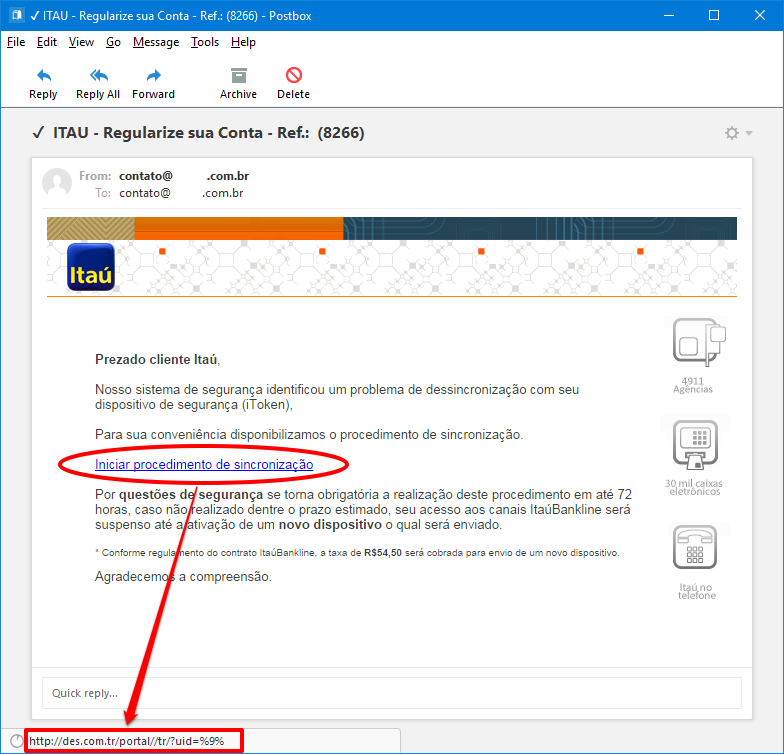

In [63]:
from google.colab import files
from IPython.display import Image

def upload_image():
  # Declare as variáveis como globais para modificá-las
  global image_content
  global image_filename

  print("Por favor, faça o upload da imagem:")
  uploaded = files.upload()

  if len(uploaded) > 0:
    # Pega o primeiro (e esperado único) arquivo uploaded
    image_filename = list(uploaded.keys())[0]
    image_content = uploaded[image_filename]

    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=image_filename, length=len(image_content)))

    # Para exibir a imagem após o upload (opcional)
    try:
      display(Image(image_content))
    except Exception as e:
      print(f"Could not display image: {e}")

  else:
      print("Nenhum arquivo foi uploaded.")

upload_image()

In [51]:
def call_model(contents):
  try:
    response= client.models.generate_content(
      model=MODEL_ID,
      contents=contents,
    )

    # Exibe a descrição da imagem
    print("\nDescrição da imagem pelo Gemini:")
    display(to_markdown(response.text))
  except Exception as e:
    print(f"Ocorreu um erro ao chamar o modelo Gemini: {e}")

In [54]:
def get_image_object():
  global image_content
  global image_filename

  if image_content is not None:
    mime_type = "image/png"

    if image_filename:
      name, ext = os.path.splitext(image_filename)
      if ext.lower() == '.jpeg' or ext.lower() == '.jpg':
        mime_type = "image/jpeg"
      elif ext.lower() == '.png':
        mime_type = "image/png"
      elif ext == '.gif':
        mime_type = "image/gif"
      elif ext == '.webp':
        mime_type = "image/webp"

      # Adicione outros tipos MIME se necessário
      print(f"Tipo MIME determinado: {mime_type}")

    # Crie um objeto Part para a imagem usando gm.Part
    # Passe os bytes da imagem para o parâmetro 'data'
    image_part_obj = types.Part.from_bytes(mime_type=mime_type, data=image_content)

    return image_part_obj

In [40]:
def get_image_description():
  global image_content
  global image_filename

  if image_content is not None:
    image_part_obj = get_image_object()
    text_part="Gere uma descrição detalhada da imagem em anexo. Lembre-se, esta descrição será utilzada como texto alternativo para questões de acessibilidade."

    contents=[
      image_part_obj,
      types.Part.from_text(text=text_part),
    ]

    print("\nEnviando imagem para o modelo Gemini...")

    call_model(contents)
  else:
    print("\nNenhuma imagem foi uploaded.")

In [45]:
get_image_description()

Tipo MIME determinado: image/png

Enviando imagem para o modelo Gemini...

Descrição da imagem pelo Gemini:


> Aqui está uma descrição detalhada da imagem em anexo:
> 
> A imagem mostra uma captura de tela de um e-mail falso do Itaú sobre a sincronização de uma conta bancária. O e-mail afirma que o sistema de segurança do Itaú detectou um problema com a sincronização do dispositivo de segurança (iToken) e que, para conveniência do cliente, o banco está disponibilizando um procedimento de sincronização. Há um botão destacado que diz "Iniciar procedimento de sincronização", que leva a um link de phishing. O e-mail também diz que, por questões de segurança, é obrigatório realizar este procedimento em até 72 horas, caso contrário, o acesso aos canais ItaúBankline será suspenso até a ativação de um novo dispositivo que será enviado. Há uma nota de rodapé que diz que, conforme o regulamento do contrato ItaúBankline, será cobrada uma taxa de R$ 54,50 para o envio de um novo dispositivo.
> 
> No canto superior direito, é possível ver três ícones: um representando 4911 agências, outro representando 30 mil caixas eletrônicos e outro representando o Itaú no telefone. O e-mail termina com um "Agradecemos a compreensão". Um link perigoso foi circulado em vermelho no canto inferior esquerdo da tela.

In [58]:
def email_fraud_detection():
  global image_content
  global image_filename

  if image_content is not None:
    image_part_obj = get_image_object()
    text_part="""
      Analise a seguinte imagem que é de um e-mail renderizado na tela do computador,
      celular ou tablet de um usuário para identificar elementos que possam indicar
      um e-mail fraudulento:

      \n\n
      Considere os seguintes fatores:

      - A imagem contém logotipos desatualizados ou de baixa qualidade da empresa/instituição? (Identifique a empresa/instituição e compare com o conhecimento visual que você possui da mesma)"
      - A formatação geral do e-mail na imagem parece profissional e consistente com a identidade visual da empresa?
      - Existem erros visuais óbvios, como desalinhamentos, fontes diferentes ou cores incomuns?
      - A imagem contém selos de segurança ou certificações que parecem falsos ou foram manipulados?
      - Existem elementos interativos na imagem (botões, links) que parecem suspeitos ou não funcionais?"
      - O layout geral da mensagem na imagem é típico de comunicações legítimas da empresa?
      - A imagem contém avisos legais ou informações de contato ausentes ou incompletas?
      - Se o e-mail alega ser de um banco, a interface visual corresponde aos padrões conhecidos desse banco?
      - O conteúdo do e-mail contém erros de gramática, ortografia ou digitação significativos?
      - A linguagem utilizada cria um senso de urgência ou ameaça (ex: "Sua conta será bloqueada imediatamente!")?
      - O e-mail solicita informações confidenciais (senhas, dados bancários, CPF, etc.)?
      - Existem links no e-mail que parecem suspeitos ou encurtados sem explicação?
      - O e-mail oferece prêmios, descontos ou ofertas que parecem irreais ou boas demais para ser verdade?
      - A saudação é genérica ("Prezado cliente") em vez de usar o nome do destinatário?
      - A assinatura do e-mail é ausente, inconsistente ou não corresponde à empresa alegada?
      - O e-mail contém anexos inesperados ou com nomes suspeitos?
      - O tom da mensagem é excessivamente formal ou informal para a comunicação da empresa?
      - O e-mail contém informações inconsistentes ou contraditórias?
      - O e-mail tenta explorar emoções como medo, ganância ou curiosidade?
      - O e-mail contém avisos legais ou políticas de privacidade que parecem falsos ou genéricos?
      - O e-mail possui número de contato e/o whastsapp? Será que esse número é de fato da instituição que alega ser?
      - O e-mail está ofertando um produto/serviço por um determinado preço e indica que este valor será reembolsado posteriormente?

      Além desses fatores acima, leve em considerações demais itens não informados,
       mas que podem indicar um e-mail fraudulento.

      No final, forneça uma nota de probabilidade de 0 a 100, onde 100 indica a maior chance de a mensagem na imagem ser de um e-mail fraudulento.
      Liste todos os indícios visuais que levaram a essa conclusão.

      Formato da resposta:
      Nota: [0-100]
      \n\n
      Indícios:
       - [Indício 1]
       - [Indício 2]

      Além disso, a imagem pode não ser de um e-mail fraudulento. Se for o caso, apenas indicar na resposta:
      N/A
    """

    contents=[
      image_part_obj,
      types.Part.from_text(text=text_part),
    ]

    print("\Analisando a imagem e verificando a chance de ser um e-mail fraudolento...")

    call_model(contents)
  else:
    print("\nNenhuma imagem foi uploaded.")


In [64]:
email_fraud_detection()

Tipo MIME determinado: image/png
\Analisando a imagem e verificando a chance de ser um e-mail fraudolento...

Descrição da imagem pelo Gemini:


> Nota: 95
> 
> Indícios:
> - O endereço de e-mail do remetente ("contato@.com.br") parece genérico e não específico para a comunicação oficial de um banco como o Itaú.
> - O link para "Iniciar procedimento de sincronização" direciona para um domínio suspeito ("http://des.com.tr/portal//tr/?uid=%9%"), que não corresponde ao domínio oficial do Itaú.
> - O e-mail menciona um problema de dessincronização com o dispositivo de segurança (iToken) e solicita que o usuário inicie um procedimento de sincronização, o que é uma tática comum em e-mails de phishing para obter informações confidenciais.
> - A mensagem cria um senso de urgência ao mencionar que o acesso aos canais ItaúBankline será suspenso em 72 horas caso o procedimento não seja realizado.
> - O e-mail informa uma taxa de R$54,50 para envio de um novo dispositivo, o que pode ser uma tentativa de enganar o usuário para que pague por algo que não precisa.
> - A presença de erros de formatação no link suspeito e o uso de caracteres especiais ("%9%") no URL são indícios de um possível ataque de phishing.
> - O logotipo do Itaú pode ser desatualizado ou de baixa qualidade, o que é comum em e-mails fraudulentos.